In [1]:
import os
import cv2

def load_images_from_folder(folder_path, ext_list=['.jpg', '.jpeg', '.png', '.bmp', 'tif']):
    images = []
    file_names = []

    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in ext_list):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            images.append(img)
            file_names.append(filename[:12])
    return images, file_names

folder_path = "test_data"
images, file_names = load_images_from_folder(folder_path)

print(f"{len(images)} adet resim yüklendi.")

100 adet resim yüklendi.


In [ ]:
import numpy as np
import pandas as pd
import cv2

df = pd.read_csv("data.csv")

label_dict = dict(zip(df["Patient"], df["histological_type"]))


rows = []

for img_bgr, file_name in zip(images, file_names):
    row= {}
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    label = label_dict[file_name]  

    row["label"] = label
    row["filename"] = file_name
    rows.append(row)

feature_df = pd.DataFrame(rows)


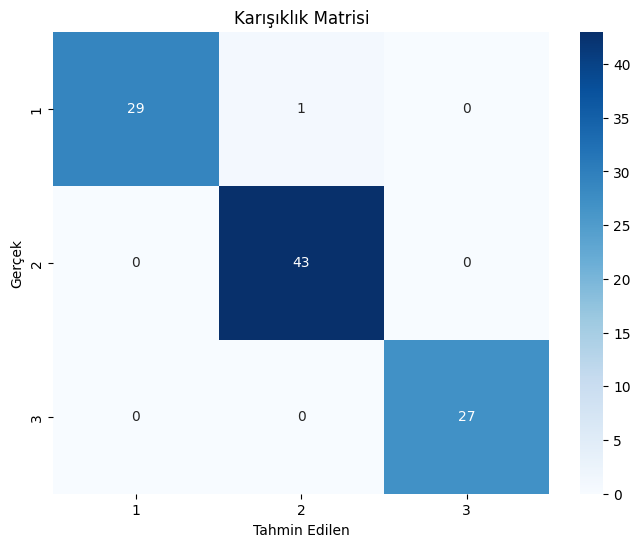

Doğruluk (Accuracy): 0.9900
Duyarlılık (Recall): 0.9889
Hassasiyet (Precision): 0.9924
F1-Skoru: 0.9905


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

class LightCNN(nn.Module):
    def __init__(self, num_classes):
        super(LightCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes + 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = 4  
model = LightCNN(num_classes)
model.load_state_dict(torch.load("modeller/model_weights.pth"))
model.eval()


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def evaluate_advanced(model, images, labels, class_names):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for image_np, label_scalar in zip(images, labels):
            image = torch.tensor(image_np).permute(2, 0, 1).float().unsqueeze(0)
            outputs = model(image)
            probs = torch.softmax(outputs, dim=1)
            _, pred = torch.max(probs, 1)

            all_probs.append(probs.squeeze().numpy())
            all_preds.append(pred.item())
            all_labels.append(label_scalar)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('Karışıklık Matrisi')
    plt.show()

    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Doğruluk (Accuracy): {acc:.4f}")
    print(f"Duyarlılık (Recall): {recall:.4f}")
    print(f"Hassasiyet (Precision): {precision:.4f}")
    print(f"F1-Skoru: {f1:.4f}")

    if len(class_names) == 2:
        y_true = np.array(all_labels)
        y_scores = np.array(all_probs)[:, 1]
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Eğrisi')
        plt.legend(loc='lower right')
        plt.show()

class_names = sorted(np.unique(feature_df['label']).astype(str))

evaluate_advanced(model, images, feature_df['label'], class_names)
